In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# # Load the data
# data = np.load('/Users/butovensmede/Downloads/data_train.npy')

# Load the data
train_data = np.load('/Users/butovensmede/Downloads/seq_data.npy')
test_data = np.load('/Users/butovensmede/Downloads/y_vector.npy')

In [35]:
# # Prepare the data
# X = torch.tensor(data[:, :, :]).float()  # Features
# y = torch.tensor(np.concatenate((np.zeros(87), np.ones(79)))).float()  # Labels (0 for AD, 1 for CN)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into train and test sets while preserving class distribution
X_train_ad, X_test_ad, y_train_ad, y_test_ad = train_test_split(
    train_data[:87], test_data[:87], test_size=0.2, random_state=42
)
X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(
    train_data[87:], test_data[87:], test_size=0.2, random_state=42
)

# Combine the AD and control data for both training and test sets
X_train = np.concatenate((X_train_ad, X_train_control))
y_train = np.concatenate((y_train_ad, y_train_control))
X_test = np.concatenate((X_test_ad, X_test_control))
y_test = np.concatenate((y_test_ad, y_test_control))

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()



In [36]:
# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [147]:
# Initialize the model
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 2
output_size = 1
dropout_prob = 0.5

model = RNN(input_size, hidden_size, num_layers, output_size, dropout_prob)

In [136]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [60]:
# Prepare DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [188]:
## Train the model
num_epochs = 20
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # Ensure that predictions and labels have compatible shapes
        loss = criterion(outputs.squeeze(), labels)  # No need for unsqueeze(1) on labels
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.6914
Epoch [2/20], Loss: 0.7004
Epoch [3/20], Loss: 0.7029
Epoch [4/20], Loss: 0.6913
Epoch [5/20], Loss: 0.6827
Epoch [6/20], Loss: 0.6854
Epoch [7/20], Loss: 0.6944
Epoch [8/20], Loss: 0.6791
Epoch [9/20], Loss: 0.6900
Epoch [10/20], Loss: 0.6926
Epoch [11/20], Loss: 0.6871
Epoch [12/20], Loss: 0.6934
Epoch [13/20], Loss: 0.6855
Epoch [14/20], Loss: 0.6992
Epoch [15/20], Loss: 0.6859
Epoch [16/20], Loss: 0.6973
Epoch [17/20], Loss: 0.6943
Epoch [18/20], Loss: 0.6990
Epoch [19/20], Loss: 0.6882
Epoch [20/20], Loss: 0.6921


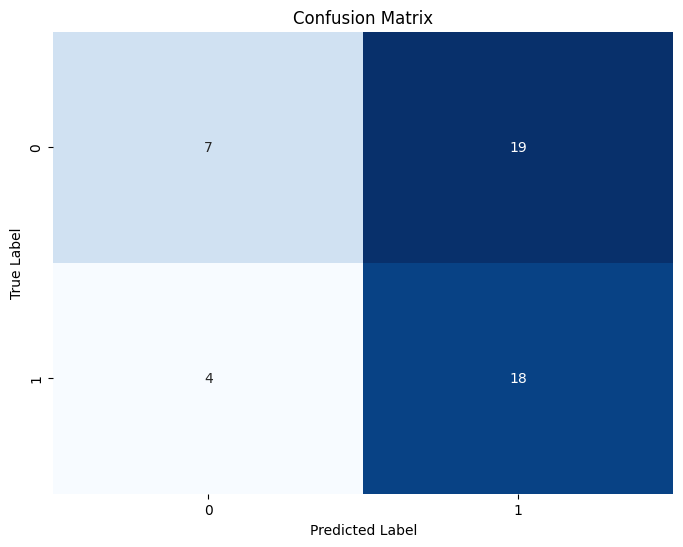

Test Accuracy: 0.5208
Precision: 0.4865
Recall: 0.8182


In [215]:
# # Evaluate the model
# with torch.no_grad():
#     outputs = model(X_test)
#     predicted = (outputs.squeeze() > 0.5).float()
#     accuracy = (predicted == y_test).float().mean()
#     print(f'Test Accuracy: {accuracy.item():.4f}')

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test)
    predicted = (outputs.squeeze() > 0.5).float()
    
    # Convert torch tensors to numpy arrays
    y_test_np = y_test.numpy()
    predicted_np = predicted.numpy()
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test_np, predicted_np)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Compute accuracy, precision, and recall using scikit-learn
    accuracy = accuracy_score(y_test_np, predicted_np)
    precision = precision_score(y_test_np, predicted_np)
    recall = recall_score(y_test_np, predicted_np)
    
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')